In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]
print("Number of M*-complete SDSS galaxies with good profile measurements = {0}".format(len(sdss)))

Number of M*-complete SDSS galaxies with good profile measurements = 229889


In [3]:
from scipy.stats import binned_statistic

logsm_bins = np.linspace(9.5, 12, 20)
logsm_table = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
median_rhalf_table, __, __ = binned_statistic(sdss['logsm_bell03_meert15'], 
                                      sdss['r50_magr_kpc_meert15'], 
                                     bins=logsm_bins)

def frac_surviving_mstar(frac_surviving_dm, a=14.2):
    return 1 - np.exp(-a*frac_surviving_dm)

def frac_rhalf_reduction(mstar_init, frac_surviving_dm, a=14.2):
    mstar_final = frac_surviving_mstar(frac_surviving_dm)*mstar_init
    logsm_init, logsm_final = np.log10([mstar_init, mstar_final])
    initial_rhalf, final_rhalf = np.interp([logsm_init, logsm_final], 
                                          logsm_table, median_rhalf_table)
    return final_rhalf/initial_rhalf



In [4]:
from galsize_models.models import moster13_based_mock, load_baseline_halocat
mock = moster13_based_mock()
print("Number of model galaxies with logM* > {0:.1f} = {1:.2e}".format(np.log10(mock['mstar'].min()),len(mock)))

Number of model galaxies with logM* > 9.0 = 1.21e+06


In [5]:
from galsize_models.models import component_size_vs_rhalo

rvir = mock['rvir_zpeak']
normalization_all = 0.0125
alpha_all = 1.
scatter_all = 0.15
size_seed=14041

mock['r50'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all, seed=size_seed)

mock['r50_orig'] = mock['r50']

from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

from galsize_models.measurements import single_component_ratios
result = single_component_ratios(mock, num_gals_max=int(2e5))
rp_mids, fracdiff_sm9p75_mock, fracdiff_sm10p25_mock, \
fracdiff_sm10p75_mock, fracdiff_sm11p25_mock = result

In [30]:
frac_surviving_dm = mock['mvir']/mock['mpeak']
mock['r50'] = mock['r50_orig']*frac_rhalf_reduction(mock['mstar'], frac_surviving_dm)

mock['r50_stripping'] = mock['r50']

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock, num_gals_max=int(2e5))
rp_mids, fracdiff_sm9p75_mock_stripping, fracdiff_sm10p25_mock_stripping, \
fracdiff_sm10p75_mock_stripping, fracdiff_sm11p25_mock_stripping = result

In [31]:
mock['r50'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all, seed=size_seed, 
                        uran=1-mock['vmax_at_mpeak_percentile'])

mock['r50_coevolution'] = mock['r50']

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

from galsize_models.measurements import single_component_ratios
result = single_component_ratios(mock, num_gals_max=int(2e5))
rp_mids, fracdiff_sm9p75_mock2, fracdiff_sm10p25_mock2, \
fracdiff_sm10p75_mock2, fracdiff_sm11p25_mock2 = result

In [92]:
def scramble_virial_radii(sample, bin_edges):
    scrambled_rvir = np.zeros(len(sample))
    for low, high in zip(bin_edges[:-1], bin_edges[1:]):
        mpeak_mask = (sample['mpeak'] >= low) & (sample['mpeak'] < high)
        num_in_bin = np.count_nonzero(mpeak_mask)
        if num_in_bin > 2:
            sample_in_bin = sample[mpeak_mask]
            randoms = np.random.choice(np.arange(num_in_bin), num_in_bin, replace=False)
            scrambled_rvir[mpeak_mask] = sample_in_bin['rvir_zpeak'][randoms.astype(int)]
    return scrambled_rvir

mock['r50'] = component_size_vs_rhalo(scrambled_rvir_zpeak, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)

mock['r50_scrambled'] = mock['r50']

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock, num_gals_max=int(2e5))
rp_mids, fracdiff_sm9p75_mock_scrambled_all, fracdiff_sm10p25_mock_scrambled_all, \
fracdiff_sm10p75_mock_scrambled_all, fracdiff_sm11p25_mock_scrambled_all = result


In [8]:
import os
repo_dirname = "/Users/aphearin/work/repositories/python/galsize_models"
output_subdirname = "galsize_models/measurements/data/two_point_functions"
output_dirname = os.path.join(repo_dirname, output_subdirname)

rp = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_rp.npy'))
wp_sdss_sm9p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_wp.npy'))
wp_sdss_sm9p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_small_wp.npy'))
wp_sdss_sm9p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_large_wp.npy'))
fracdiff_sm9p75_smbell = (wp_sdss_sm9p75_smbell_large-wp_sdss_sm9p75_smbell_small)/wp_sdss_sm9p75_smbell

wp_sdss_sm10p0_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_wp.npy'))
wp_sdss_sm10p0_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_small_wp.npy'))
wp_sdss_sm10p0_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_large_wp.npy'))
fracdiff_sm10p0_smbell = (wp_sdss_sm10p0_smbell_large-wp_sdss_sm10p0_smbell_small)/wp_sdss_sm10p0_smbell

wp_sdss_sm10p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_wp.npy'))
wp_sdss_sm10p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_small_wp.npy'))
wp_sdss_sm10p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_large_wp.npy'))
fracdiff_sm10p25_smbell = (wp_sdss_sm10p25_smbell_large-wp_sdss_sm10p25_smbell_small)/wp_sdss_sm10p25_smbell

wp_sdss_sm10p5_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_wp.npy'))
wp_sdss_sm10p5_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_small_wp.npy'))
wp_sdss_sm10p5_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_large_wp.npy'))
fracdiff_sm10p5_smbell = (wp_sdss_sm10p5_smbell_large-wp_sdss_sm10p5_smbell_small)/wp_sdss_sm10p5_smbell

wp_sdss_sm10p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_wp.npy'))
wp_sdss_sm10p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_small_wp.npy'))
wp_sdss_sm10p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_large_wp.npy'))
fracdiff_sm10p75_smbell = (wp_sdss_sm10p75_smbell_large-wp_sdss_sm10p75_smbell_small)/wp_sdss_sm10p75_smbell

wp_sdss_sm11_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_wp.npy'))
wp_sdss_sm11_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_small_wp.npy'))
wp_sdss_sm11_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_large_wp.npy'))
fracdiff_sm11_smbell = (wp_sdss_sm11_smbell_large-wp_sdss_sm11_smbell_small)/wp_sdss_sm11_smbell

wp_sdss_sm11p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_wp.npy'))
wp_sdss_sm11p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_small_wp.npy'))
wp_sdss_sm11p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_large_wp.npy'))
fracdiff_sm11p25_smbell = (wp_sdss_sm11p25_smbell_large-wp_sdss_sm11p25_smbell_small)/wp_sdss_sm11p25_smbell

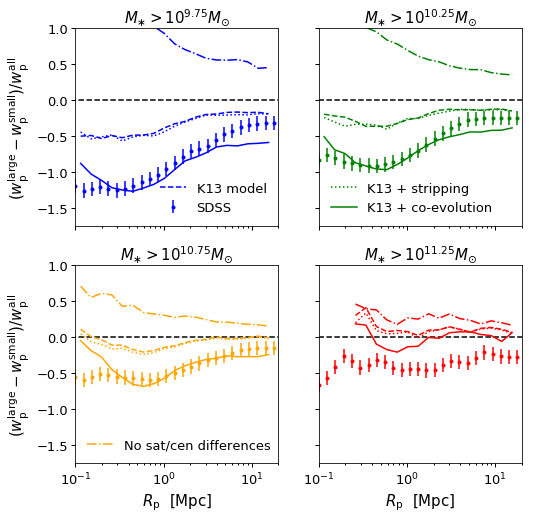

In [104]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                                             figsize=(8, 8))

axes = ax1, ax2, ax3, ax4

for ax in axes:
    ylim = ax.set_ylim(-1.75, 1)
    xlim = ax.set_xlim(0.1, 20)
    xscale = ax.set_xscale('log')
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

    
__=ax4.errorbar(rp, fracdiff_sm11p25_smbell, 0.1, fmt='.', color='red')
__=ax3.errorbar(rp, fracdiff_sm10p75_smbell, 0.1, fmt='.', color='orange')
__=ax2.errorbar(rp, fracdiff_sm10p25_smbell, 0.1, fmt='.', color='green')
__=ax1.errorbar(rp, fracdiff_sm9p75_smbell, 0.1, fmt='.', color='blue', label='SDSS')

__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock[3:],'--', color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock, '--', color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock,'--', color='green')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock,'--', color='blue', label=r'K13 model')

__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_stripping[3:], ':', color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_stripping, ':', color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_stripping, ':', color='green', label=r'K13 + stripping')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_stripping,':', color='blue')

__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock2[3:], color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock2, color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock2, color='green', label=r'K13 + co-evolution')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock2, color='blue')

__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_scrambled_all[3:], '-.', color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_scrambled_all, '-.', color='orange', label=r'No sat/cen differences')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_scrambled_all, '-.', color='green')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_scrambled_all, '-.', color='blue')

__=ax4.set_title(r'$M_{\ast} > 10^{11.25}M_{\odot}$')
__=ax3.set_title(r'$M_{\ast} > 10^{10.75}M_{\odot}$')
__=ax2.set_title(r'$M_{\ast} > 10^{10.25}M_{\odot}$')
__=ax1.set_title(r'$M_{\ast} > 10^{9.75}M_{\odot}$')

ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')

leg1 = ax1.legend()
leg2 = ax2.legend()
leg3 = ax3.legend()
le43 = ax4.legend()

figname = 'size_clustering_ratios_stripping_coevolution.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


In [20]:
mpeak_mask = (mock['mpeak'] > 1e13) & (mock['mpeak'] < 2.5e13)
sample = mock[mpeak_mask]

In [21]:
sample.sort('vmax_at_mpeak_percentile')

In [22]:
sample['r50'][:1000].mean(), sample['r50'][-1000:].mean()

(14.667378956812934, 5.4154354515471503)

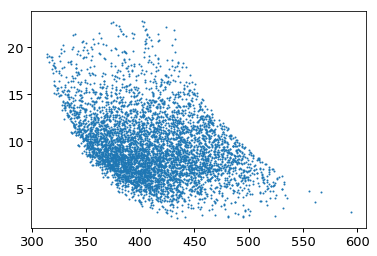

In [23]:
fig, ax = plt.subplots(1, 1)

__=ax.scatter(sample['vmax_mpeak'], sample['r50'], s=1)

In [27]:
mpeak_mask1 = (mock['mpeak'] > 10**11.75) & (mock['mpeak'] < 10**12.)
mpeak_mask2 = (mock['mpeak'] > 10**12.75) & (mock['mpeak'] < 10**13.25)

cen_mask1 = mpeak_mask1 & (mock['upid'] == -1)
true_cen_mask1 = cen_mask1 & (mock['scale_factor_firstacc'] > 1)
bsp_cen_mask1 = cen_mask1 & (mock['scale_factor_firstacc'] < 0.9) 
sat_mask1 = mpeak_mask1  & (mock['upid'] != -1)

cen_mask2 = mpeak_mask2 & (mock['upid'] == -1)
true_cen_mask2 = cen_mask2 & (mock['scale_factor_firstacc'] > 1)
bsp_cen_mask2 = cen_mask2 & (mock['scale_factor_firstacc'] < 1)
sat_mask2 = mpeak_mask2  & (mock['upid'] != -1)

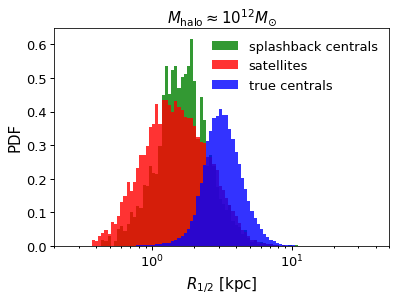

In [32]:
fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')
xlim = ax.set_xlim(0.2, 50)

r50_bins1 = np.logspace(-1, 1.25, 100)
__=ax.hist(mock['r50_coevolution'][bsp_cen_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='green', label='splashback centrals')
__=ax.hist(mock['r50_coevolution'][sat_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='red', label='satellites')
__=ax.hist(mock['r50_coevolution'][true_cen_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='blue', label='true centrals')

leg = ax.legend(loc=1)
xlabel = ax.set_xlabel(r'$R_{1/2}$ $[{\rm kpc}]$')
ylabel = ax.set_ylabel(r'PDF')
title = ax.set_title(r'$M_{\rm halo} \approx 10^{12} M_{\odot}$')


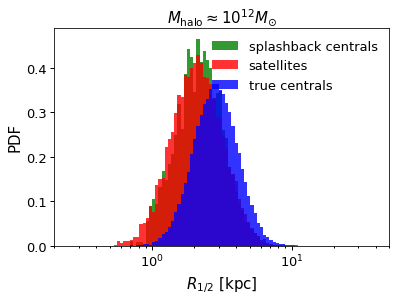

In [33]:
fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')
xlim = ax.set_xlim(0.2, 50)

r50_bins1 = np.logspace(-1, 1.25, 100)
__=ax.hist(mock['r50_orig'][bsp_cen_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='green', label='splashback centrals')
__=ax.hist(mock['r50_orig'][sat_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='red', label='satellites')
__=ax.hist(mock['r50_orig'][true_cen_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='blue', label='true centrals')

leg = ax.legend(loc=1)
xlabel = ax.set_xlabel(r'$R_{1/2}$ $[{\rm kpc}]$')
ylabel = ax.set_ylabel(r'PDF')
title = ax.set_title(r'$M_{\rm halo} \approx 10^{12} M_{\odot}$')


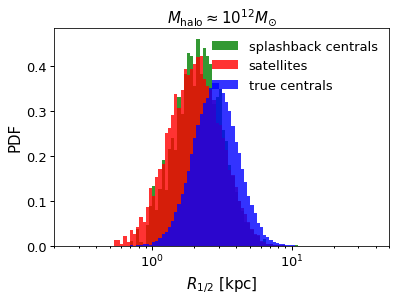

In [34]:
fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')
xlim = ax.set_xlim(0.2, 50)

r50_bins1 = np.logspace(-1, 1.25, 100)
__=ax.hist(mock['r50_stripping'][bsp_cen_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='green', label='splashback centrals')
__=ax.hist(mock['r50_stripping'][sat_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='red', label='satellites')
__=ax.hist(mock['r50_stripping'][true_cen_mask1], bins=r50_bins1, normed=True, alpha=0.8,
          color='blue', label='true centrals')

leg = ax.legend(loc=1)
xlabel = ax.set_xlabel(r'$R_{1/2}$ $[{\rm kpc}]$')
ylabel = ax.set_ylabel(r'PDF')
title = ax.set_title(r'$M_{\rm halo} \approx 10^{12} M_{\odot}$')


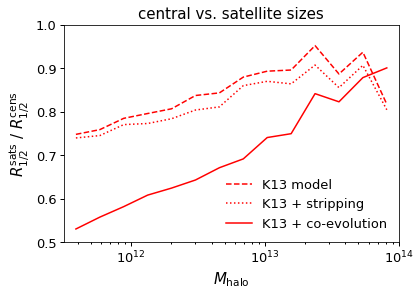

In [89]:
mpeak_bins = np.logspace(11.5, 14, 15)
mpeak_mids = 10**(0.5*(np.log10(mpeak_bins[:-1]) + np.log10(mpeak_bins[1:])))

drhalf_spl_orig = np.zeros_like(mpeak_mids)
drhalf_spl_stripping = np.zeros_like(mpeak_mids)
drhalf_spl_coevolution = np.zeros_like(mpeak_mids)
drhalf_sat_orig = np.zeros_like(mpeak_mids)
drhalf_sat_stripping = np.zeros_like(mpeak_mids)
drhalf_sat_coevolution = np.zeros_like(mpeak_mids)

frac_rhalf_spl_orig = np.zeros_like(mpeak_mids)
frac_rhalf_spl_stripping = np.zeros_like(mpeak_mids)
frac_rhalf_spl_coevolution = np.zeros_like(mpeak_mids)
frac_rhalf_sat_orig = np.zeros_like(mpeak_mids)
frac_rhalf_sat_stripping = np.zeros_like(mpeak_mids)
frac_rhalf_sat_coevolution = np.zeros_like(mpeak_mids)


for i, low, high in zip(range(len(mpeak_mids)), mpeak_bins[:-1], mpeak_bins[1:]):
    mask = (mock['mpeak'] > low) & (mock['mpeak'] < high)
    sample = mock[mask]
    cenmask = sample['upid'] == -1
    true_cenmask = cenmask & (sample['scale_factor_firstacc'] > 1)
    spl_cenmask = cenmask & (sample['scale_factor_firstacc'] < 1)
    logrhalf_truecen_orig = np.log10(np.median(sample['r50_orig'][true_cenmask]))
    logrhalf_splcen_orig = np.log10(np.median(sample['r50_orig'][spl_cenmask]))
    logrhalf_sat_orig = np.log10(np.median(sample['r50_orig'][~cenmask]))    
    drhalf_spl_orig[i] = logrhalf_splcen_orig - logrhalf_truecen_orig
    drhalf_sat_orig[i] = logrhalf_sat_orig - logrhalf_truecen_orig
    frac_rhalf_sat_orig[i] = (10**logrhalf_sat_orig)/(10**logrhalf_truecen_orig)
    
    logrhalf_truecen_stripping = np.log10(np.median(sample['r50_stripping'][true_cenmask]))
    logrhalf_splcen_stripping = np.log10(np.median(sample['r50_stripping'][spl_cenmask]))
    logrhalf_sat_stripping = np.log10(np.median(sample['r50_stripping'][~cenmask]))    
    drhalf_spl_stripping[i] = logrhalf_splcen_stripping - logrhalf_truecen_stripping
    drhalf_sat_stripping[i] = logrhalf_sat_stripping - logrhalf_truecen_stripping
    frac_rhalf_sat_stripping[i] = (10**logrhalf_sat_stripping)/(10**logrhalf_truecen_stripping)

    logrhalf_truecen_coevolution = np.log10(np.median(sample['r50_coevolution'][true_cenmask]))
    logrhalf_splcen_coevolution = np.log10(np.median(sample['r50_coevolution'][spl_cenmask]))
    logrhalf_sat_coevolution = np.log10(np.median(sample['r50_coevolution'][~cenmask]))    
    drhalf_spl_coevolution[i] = logrhalf_splcen_coevolution - logrhalf_truecen_coevolution
    drhalf_sat_coevolution[i] = logrhalf_sat_coevolution - logrhalf_truecen_coevolution
    frac_rhalf_sat_coevolution[i] = (10**logrhalf_sat_coevolution)/(10**logrhalf_truecen_coevolution)


from scipy.signal import savgol_filter

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

# __=ax.plot(mpeak_mids, savgol_filter(drhalf_spl_coevolution, 7, 3), color='green')
# __=ax.plot(mpeak_mids, drhalf_sat_coevolution, color='red')
# __=ax.plot(mpeak_mids, savgol_filter(drhalf_spl_orig, 7, 3), '--', color='green')
# __=ax.plot(mpeak_mids, drhalf_sat_orig, '--', color='red')
# __=ax.plot(mpeak_mids, savgol_filter(drhalf_spl_stripping, 7, 3), ':', color='green')
# __=ax.plot(mpeak_mids, drhalf_sat_stripping, ':', color='red')

__=ax.plot(mpeak_mids, frac_rhalf_sat_orig, '--', color='red', 
          label=r'K13 model')
__=ax.plot(mpeak_mids, frac_rhalf_sat_stripping, ':', color='red', 
          label=r'K13 + stripping')
__=ax.plot(mpeak_mids, frac_rhalf_sat_coevolution, color='red', 
          label=r'K13 + co-evolution')

xlim = ax.set_xlim(10**11.5, 10**14)
ylim = ax.set_ylim(0.5, 1)
title = ax.set_title(r'central vs. satellite sizes')
xlabel = ax.set_xlabel(r'$M_{\rm halo}$')
ylabel = ax.set_ylabel(r'$R_{1/2}^{\rm sats}\ /\ R_{1/2}^{\rm cens}$')
__=ax.plot(np.logspace(11, 15, 100), np.zeros(100), ':', color='gray')

leg = ax.legend()

figname = 'sat_vs_cen_sizes_fracdiff.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
